In [150]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn import metrics
import shap
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.metrics import Precision, Recall

plt.style.use('dark_background')
pd.set_option('display.max_columns', None)

nanny = pd.read_csv('dane_klasyfikacja.csv')

I will build models that will determine based on the data of an advertisement whether the proposed salary for a nanny is higher or lower than the assumed threshold.
I'm checking what the average rate is for a nanny. Offers below the average will be classified as low-paid, while offers above it will be classified as well-paid

In [151]:
avg_salary = nanny.max_stawka.mean()
avg_salary.round(3)

29.525

In [152]:
median = nanny.max_stawka.median()
median

30.0

creating a new column that classifies the rate as low or high:

In [153]:
def salary_check(row):
    if row['max_stawka'] <= median:
            val = 0 #low salary
    else:
            val = 1 #high salary
        
    return val

creating new column to count low, high and median values:

In [154]:
def count_30(row):
    if row['max_stawka'] < median:
            val = 0 
    elif row['max_stawka'] == median:
            val = 30 
    else:
            val = 1 
        
    return val

In [155]:
nanny['class'] = nanny.apply(salary_check, axis=1)

In [156]:
nanny['class_number'] = nanny.apply(count_30, axis=1)

In [157]:
nanny['class'].unique()

array([0, 1])

checking the distribution of data:

<AxesSubplot:xlabel='class', ylabel='count'>

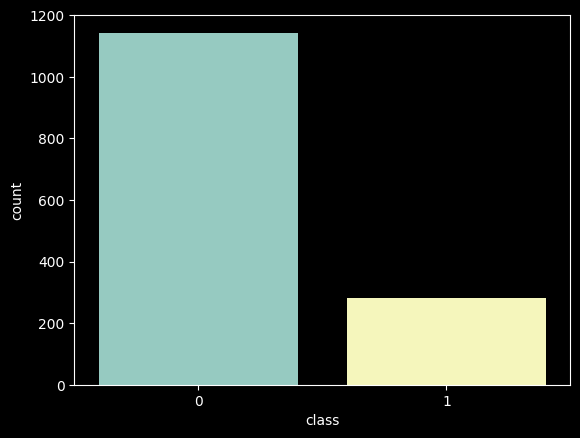

In [158]:
sns.countplot(x = 'class', data = nanny, dodge = True)

<AxesSubplot:xlabel='class_number', ylabel='count'>

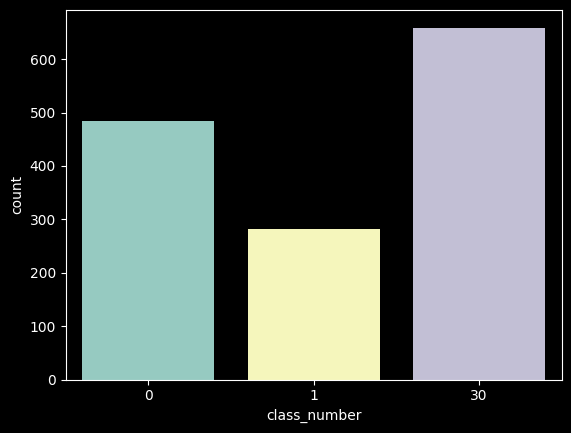

In [159]:
sns.countplot(x = 'class_number', data = nanny, dodge = True)

checking the distribution of salary:

<AxesSubplot:>

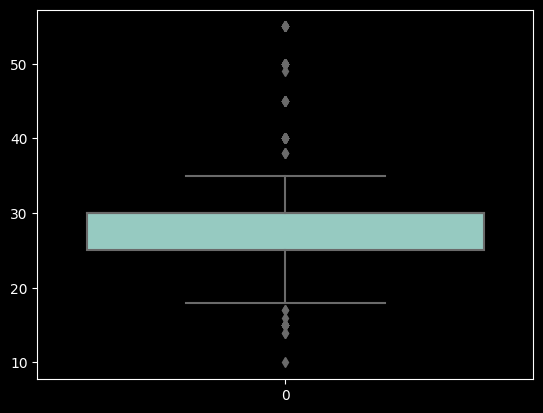

In [160]:
sns.boxplot(nanny['max_stawka'])

<AxesSubplot:xlabel='max_stawka', ylabel='Count'>

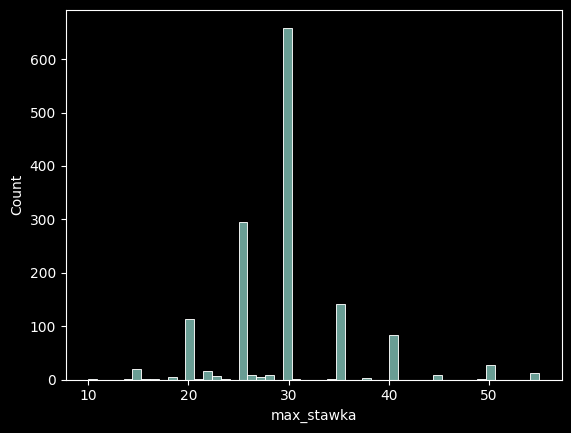

In [161]:
sns.histplot(data = nanny, x="max_stawka")

rounding down the average age of children:

In [162]:
for a in nanny['sredni_wiek_dzieci'].index:
    row = nanny['sredni_wiek_dzieci'][a]
    row = int(row)

I'm checking if classification is correct on random sample:

In [165]:
nanny[['max_stawka', 'class']].sample(5)

,max_stawka,class
982,30,0
396,23,0
145,25,0
634,35,1
1376,40,1


preparing the dataset and determining features versus target:

In [166]:
random_state = 21

In [167]:
len(nanny)

1424

In [168]:
null_df = nanny.isnull()
all_null_rows = null_df.all(axis=1)

In [169]:
len(all_null_rows)

1424

In [171]:
nanny = nanny.drop(columns=['class_number', 'Unnamed: 0', 'max_stawka', 'sredni_oczekiwany_wiek_n', 'autor', 'data_pobrania', 'data_zamieszczenia_ogloszenia'])

In [172]:
nanny = pd.get_dummies(nanny, columns = ['jezyk1', 'jezyk2', 'zrodlo_ogloszenia', 'miasto'])

In [173]:
nanny = nanny[nanny.notnull().all(axis=1)]

In [174]:
X = nanny.drop(columns=['class'])
y = nanny['class']

In [175]:
X.columns

Index(['Pełny etat', 'Część etatu', 'Dorywczo', 'Jednorazowo',
       'Osoba niepaląca', 'Osoba ze zdjęciem', 'Akceptuje obecność zwierząt',
       'Osoba z doświadczeniem w pracy z bliźniakami', 'Gotowanie', 'Spacery',
       'Kreatywność', 'Muzyka', 'Sporty', 'Porządki', 'Pranie',
       'Posiada prawo jazdy', 'liczba_dzieci', 'data_zam_regresja',
       'sredni_wiek_dzieci', 'srednie_oczekiwane_doswiadczenie', 'Dziewczynka',
       'Chłopiec', 'jezyk1_Polski', 'jezyk2_Polski',
       'zrodlo_ogloszenia_agencja', 'zrodlo_ogloszenia_k',
       'zrodlo_ogloszenia_m', 'miasto_bydgoszcz', 'miasto_gdańsk',
       'miasto_gdynia', 'miasto_gliwice', 'miasto_józefosław',
       'miasto_katowice', 'miasto_kielce', 'miasto_konstancin-jeziorna',
       'miasto_kraków', 'miasto_legionowo', 'miasto_lublin', 'miasto_nadarzyn',
       'miasto_ożarów', 'miasto_piaseczno', 'miasto_piastów', 'miasto_poznań',
       'miasto_pruszków', 'miasto_raszyn', 'miasto_rzeszów', 'miasto_szczecin',
       'miasto

 splitting the dataset into a training set and a test set:

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = random_state)
print(len(X), len(X_train), len(X_test), len(y_train), len(y_test))

1424 996 428 996 428


checking the results for individual algorithms without setting parameters:

In [177]:
knn = KNeighborsClassifier()

In [178]:
logreg = LogisticRegression(random_state = random_state)

In [179]:
dtc = DecisionTreeClassifier()

In [180]:
rfc = RandomForestClassifier(random_state=random_state)

In [181]:
xgb = XGBClassifier(random_state=random_state)

In [182]:
def checking_algo(algorytm):
    
    algorytm.fit(X_train, y_train)
    y_pred = algorytm.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    
    print(algorytm)
    print("Accuracy:", accuracy.round(3))
    print("Precision:", precision.round(3))
    print("Recall:", recall.round(3), '\n')

In [183]:
algo_list = [knn, logreg, dtc, rfc, xgb]

In [184]:
for a in algo_list:
    checking_algo(a)

KNeighborsClassifier()
Accuracy: 0.804
Precision: 0.653
Recall: 0.558 

LogisticRegression(random_state=21)
Accuracy: 0.799
Precision: 0.636
Recall: 0.555 

DecisionTreeClassifier()
Accuracy: 0.738
Precision: 0.596
Recall: 0.604 



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


RandomForestClassifier(random_state=21)
Accuracy: 0.813
Precision: 0.698
Recall: 0.559 

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=21,
              reg_alpha=0, reg_lambda=1, ...)
Accuracy: 0.811
Precision: 0.686
Recall: 0.631 



CROSS-VALIDATION

In [185]:
def cross_val(alg, X, y):
        scores = cross_val_score(alg, X, y, cv=5)
        cv_preds = cross_val_predict(alg, X, y, cv=5)
    
        print(alg)
        print("Accuracy:", accuracy_score(y, cv_preds))
        print("Precision:", precision_score(y, cv_preds))
        print("Recall:", recall_score(y, cv_preds), '\n')

 checking which model performs the best without hpt:

In [186]:
for a in algo_list:
    cross_val(a, X, y)

KNeighborsClassifier()
Accuracy: 0.7872191011235955
Precision: 0.36904761904761907
Recall: 0.1103202846975089 



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

LogisticRegression(random_state=21)
Accuracy: 0.7872191011235955
Precision: 0.4153846153846154
Recall: 0.19217081850533807 

DecisionTreeClassifier()
Accuracy: 0.6931179775280899
Precision: 0.30303030303030304
Recall: 0.42704626334519574 

RandomForestClassifier(random_state=21)
Accuracy: 0.8258426966292135
Precision: 0.6513761467889908
Recall: 0.2526690391459075 

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='au

Adding parameters to the models:

In [189]:
feature_names = X.columns

In [190]:
results = {'model':[], 'precision_train':[], 'precision_test':[], 'recall_train':[], 'recall_test':[], 'f1_train':[], 'f1_test':[], 'auc_train':[], 'auc_test':[] }

In [191]:
params_logreg = dict(
        penalty = ['none', 'l2'],
        solver = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
        C = [1.0, 2.0, 3.0, 4.0, 5.0]
    )

In [192]:
max_depth = list(range(1,10))
n_estimators = list(range(25,250,25))

params_xgb = dict(max_depth=max_depth, n_estimators=n_estimators)

In [193]:
criterion = ['gini', 'entropy']
max_depth = list(range(1,20))
min_samples_split = list(range(1,20))
min_samples_leaf= list(range(1,20))

params_dtc = dict(criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf = min_samples_leaf)

In [194]:
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2] # distance metric parameter that determines the type of distance used to measure 
#the similarity between two data points

params_knn = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

In [195]:
n_estimators = list(range(40,300,10))
max_depth = list(range(1,20))
min_samples_split = list(range(1,20))
min_samples_leaf = list(range(1,20))

params_rfc = dict(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

Function with hpt that chooses best parameters for the model:

In [196]:
def best_model(params, model):
    
    hpt = RandomizedSearchCV(model, params, cv=3)
    search = hpt.fit(X_train, y_train)
    print("Best hyperparameters: ", hpt.best_params_)
    model_final = search.best_estimator_
    
    y_test_pred = model_final.predict(X_test)
    y_train_pred = model_final.predict(X_train)
    
    y_test_pred_proba = model_final.predict_proba(X_test) 
    y_train_pred_proba = model_final.predict_proba(X_train)
    
    return {'model': model_final, 'y_test_pred':y_test_pred, 'y_train_pred':y_train_pred,
            'y_test_pred_proba':y_test_pred_proba, 'y_train_pred_proba':y_train_pred_proba}

Function that checks metrics:

In [197]:
def tree_models_scores(model_dec_tree, nazwa):
    model = model_dec_tree['model']
    y_test_pred = model_dec_tree['y_test_pred']
    y_train_pred = model_dec_tree['y_train_pred']
    y_test_pred_proba = model_dec_tree['y_test_pred_proba']
    y_train_pred_proba = model_dec_tree['y_train_pred_proba']
    feature_importances = model.feature_importances_
    
    indices = feature_importances.argsort()[::-1][:5]
    sorted_feature_importances = feature_importances[indices]
    sorted_feature_names = [feature_names[i] for i in indices]
        
    precision_train = precision_score(y_train, y_train_pred, average='macro')
    precision_test = precision_score(y_test, y_test_pred, average='macro')
    recall_train = recall_score(y_train, y_train_pred, average='macro')
    recall_test = recall_score(y_test, y_test_pred, average='macro')
    f1_train = f1_score(y_train, y_train_pred, average = 'binary')
    f1_test = f1_score(y_test, y_test_pred, average = 'binary')
        
    results['model'].append(nazwa)
    results['precision_train'].append(precision_train.round(3))
    results['precision_test'].append(precision_test.round(3))
    results['recall_train'].append(recall_train.round(3))
    results['recall_test'].append(recall_test.round(3))
    results['f1_train'].append(f1_train.round(3))
    results['f1_test'].append(f1_test.round(3))
    
    wynik = {'feature_importances': feature_importances}
    return wynik

Function that calculates auc:

In [198]:
def auc(y, y_pred_proba):    
    fpr, tpr, thresholds = roc_curve(y, y_pred_proba[:,1])
    auc = metrics.roc_auc_score(y, y_pred_proba[:,1])
    return {'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds, 'auc': auc}

Function that shows roc graphs:

In [199]:
def roc_graph(fpr_train, tpr_train, auc_train, fpr_test, tpr_test, auc_test):
    plt.figure(figsize=(8, 5))
    results['auc_test'].append(auc_test.round(3))
    results['auc_train'].append(auc_train.round(3))
    plt.plot(fpr_train, tpr_train, label="AUC train="+str(auc_train.round(3)))
    plt.plot(fpr_test, tpr_test, label="AUC test="+str(auc_test.round(3)))
    plt.title('ROC Curve and Probability Distribution')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=0)
    plt.show()

Function that checks probability distribution:

In [200]:
def probabilitity_dist(y_train_pred_proba, y_test_pred_proba):
    plt.figure(figsize=(8, 5))
    plt.hist(y_train_pred_proba[:,1], label="Train probability")
    plt.hist(y_test_pred_proba[:,1], label="Test probability")
    plt.title('Probability Distribution')
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.legend(loc=0)

Function with precision-recall graph:

In [201]:
def precision_recall(y_train_pred_proba, y_test_pred_proba):
    plt.figure(figsize=(8, 5))
    precision, recall, thresholds_train_pr = precision_recall_curve(y_train,y_train_pred_proba[:,1])
    precision_t, recall_t, thresholds_test_pr = precision_recall_curve(y_test,y_test_pred_proba[:,1])
    plt.plot(recall, precision, label='Train Precision-Recall Curve')
    plt.plot(recall_t, precision_t, label='Test Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc=2)

Funcktion that checks most important features:

In [202]:
def feature_importances(features):
    
    plt.figure(figsize=(8, 5))
    indices = np.argsort(features)[::-1][:5]
    sorted_feature_importances = features[indices]
    sorted_feature_names = [feature_names[i] for i in indices]
    plt.bar(range(len(sorted_feature_importances)), sorted_feature_importances)
    plt.xticks(range(len(sorted_feature_importances)), sorted_feature_names, rotation='vertical')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Feature Importances')

Function with shap graph:

In [203]:
def szap(algo):
    plt.figure(figsize=(10, 8))
    vectorizer = TfidfVectorizer()
    explainer = shap.Explainer(algo, X_test, feature_names=X.columns)
    shap_values = explainer(X_test)
    shap.plots.beeswarm(shap_values[:,:,1])

We combine all the functions in one:

In [204]:
def all_tree(model, params, nazwa):
    
    model_dec_tree = best_model(params, model)
    model = model_dec_tree['model']
    y_test_pred = model_dec_tree['y_test_pred']
    y_train_pred = model_dec_tree['y_train_pred']
    y_test_pred_proba = model_dec_tree['y_test_pred_proba']
    y_train_pred_proba = model_dec_tree['y_train_pred_proba']
    
    drzewo_dec = tree_models_scores(model_dec_tree, nazwa)
    features_tree = drzewo_dec['feature_importances']
    
    auc_tree_train = auc(y_train, y_train_pred_proba)
    fpr_t_train = auc_tree_train['fpr']
    tpr_t_train = auc_tree_train['tpr']
    thresholds_t_train = auc_tree_train['thresholds']
    auc_t_train = auc_tree_train['auc']
    
    auc_tree_test = auc(y_test, y_test_pred_proba)
    fpr_t_test = auc_tree_test['fpr']
    tpr_t_test = auc_tree_test['tpr']
    thresholds_t_test = auc_tree_test['thresholds']
    auc_t_test = auc_tree_test['auc']
    
    roc_graph(fpr_t_train, tpr_t_train, auc_t_train, fpr_t_test, tpr_t_test, auc_t_test)
    probabilitity_dist(y_train_pred_proba, y_test_pred_proba)
    precision_recall(y_train_pred_proba, y_test_pred_proba)
    feature_importances(features_tree)
    szap(model)

In [205]:
algo_drzewa = [dtc, rfc, xgb]
param_drzewa = [params_dtc, params_rfc, params_xgb]
nazwy = ['dec_tree', 'random_f', 'xgb_tree']

dec_tree
Best hyperparameters:  {'min_samples_split': 18, 'min_samples_leaf': 19, 'max_depth': 6, 'criterion': 'entropy'}


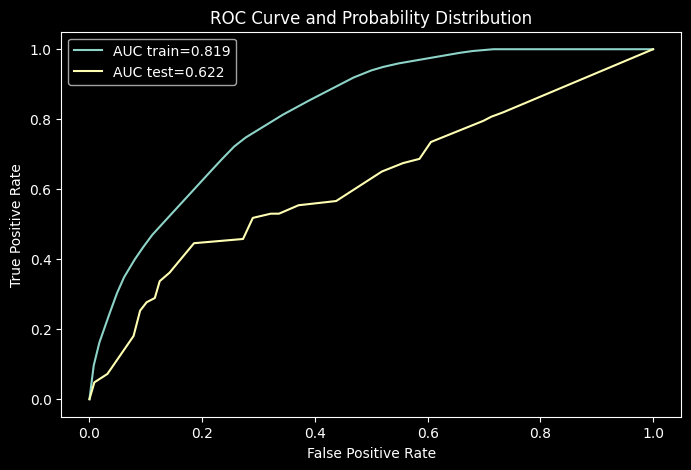

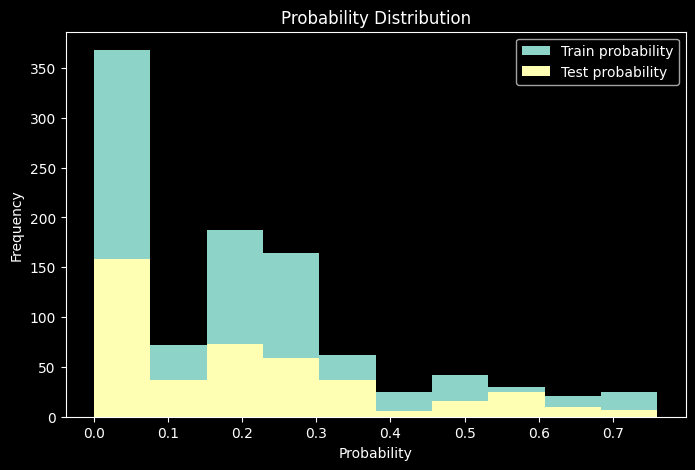

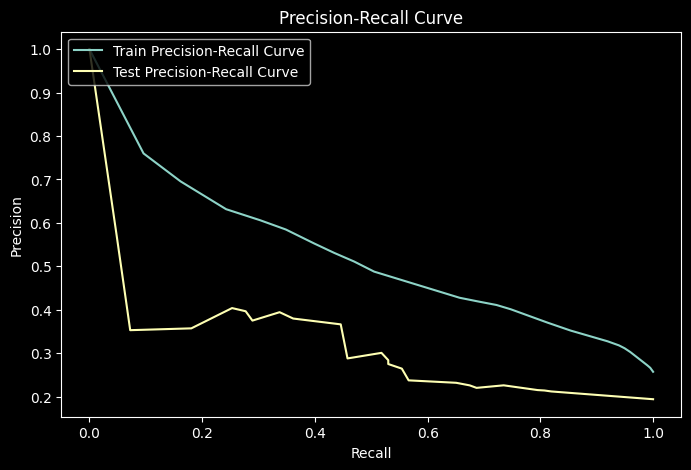

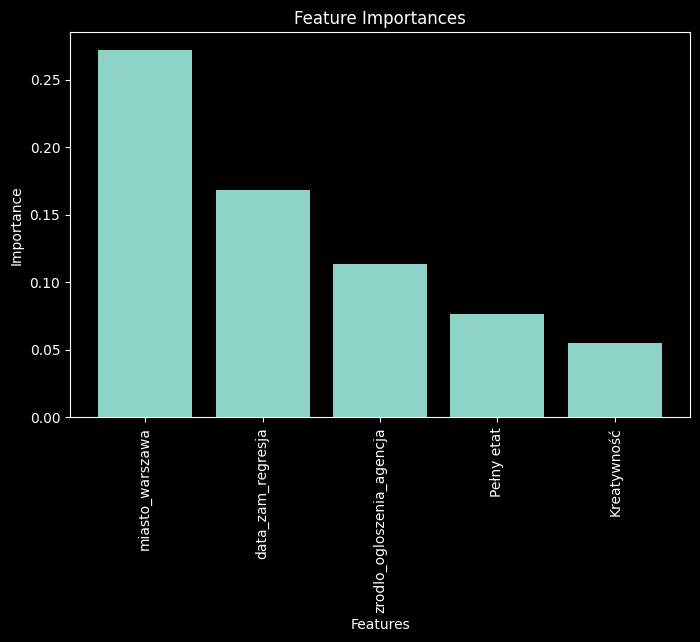

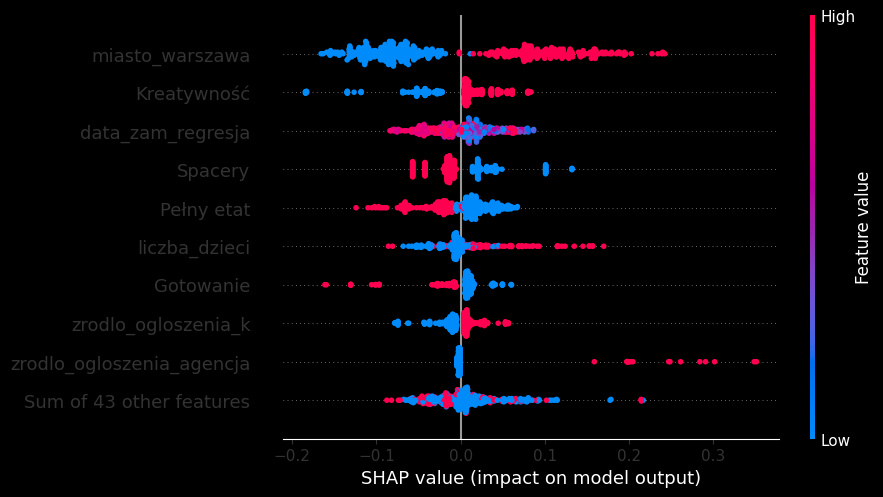

random_f
Best hyperparameters:  {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 8}


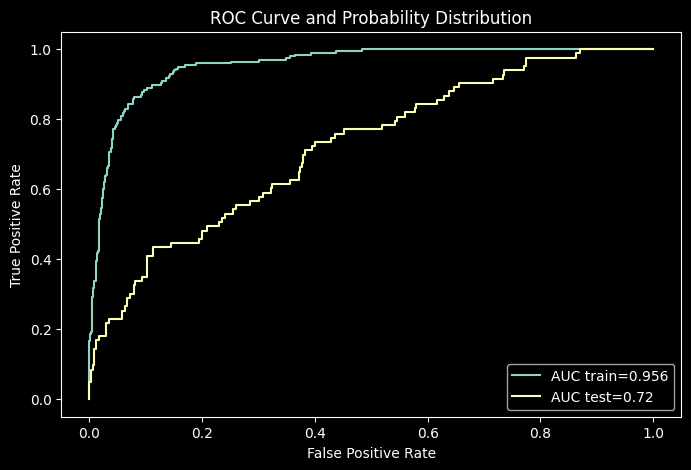

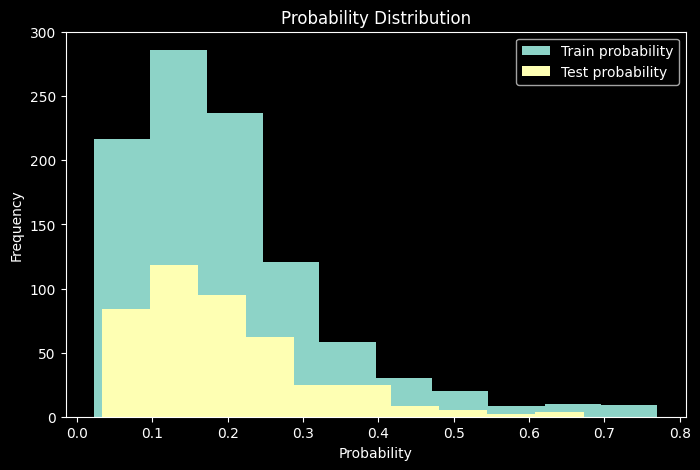

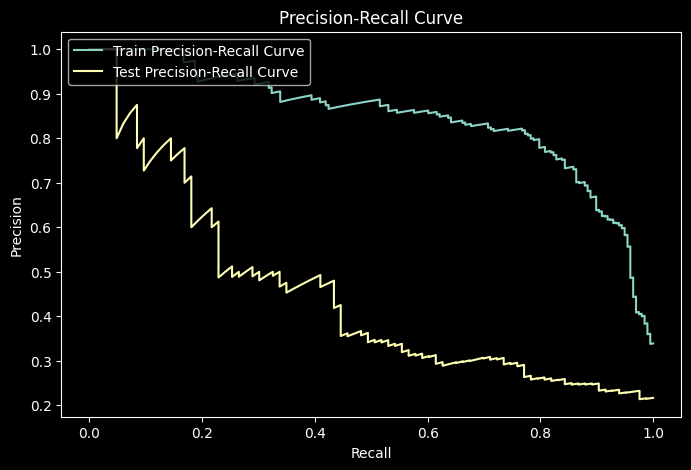

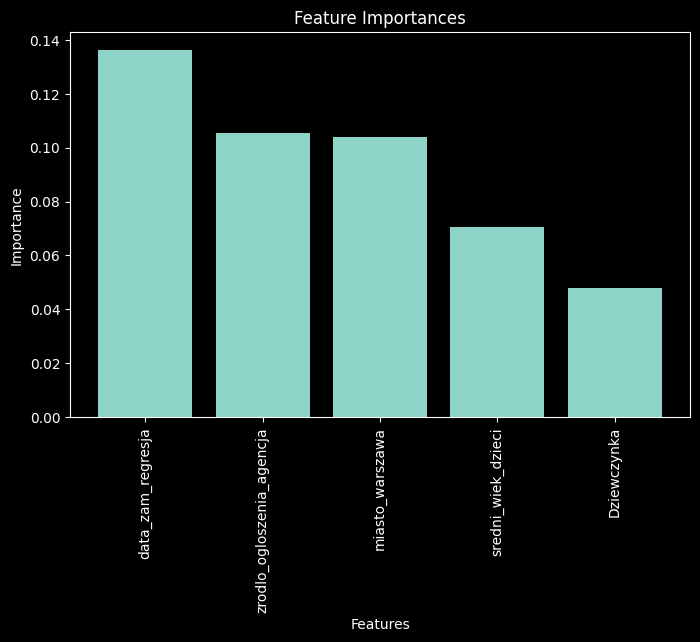

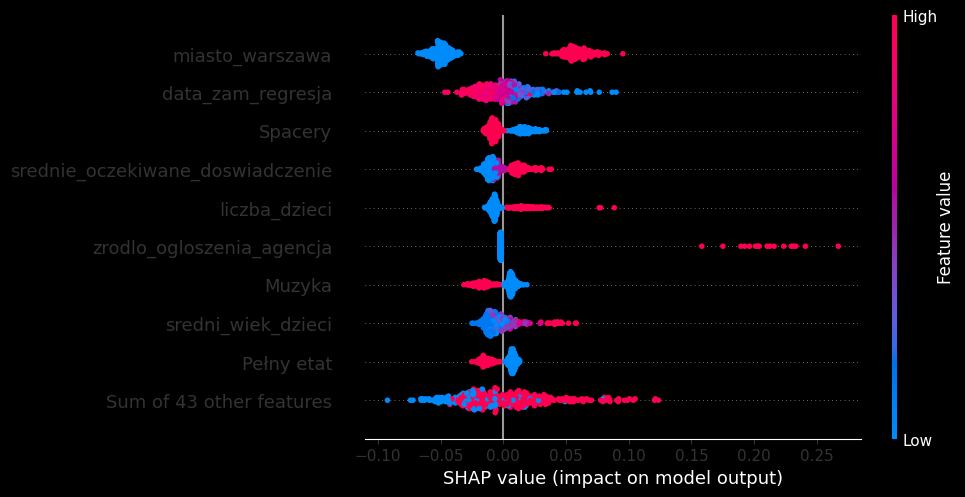

xgb_tree
Best hyperparameters:  {'n_estimators': 25, 'max_depth': 8}


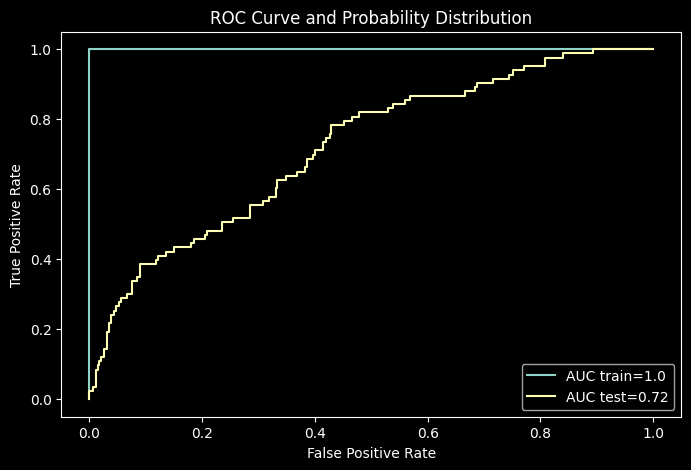

IndexError: too many indices for array

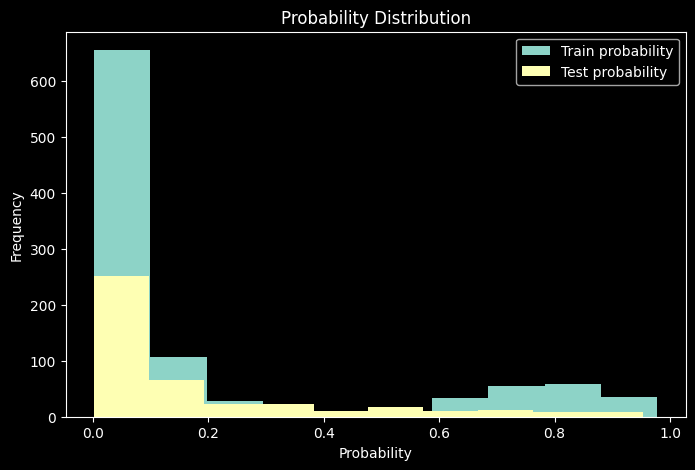

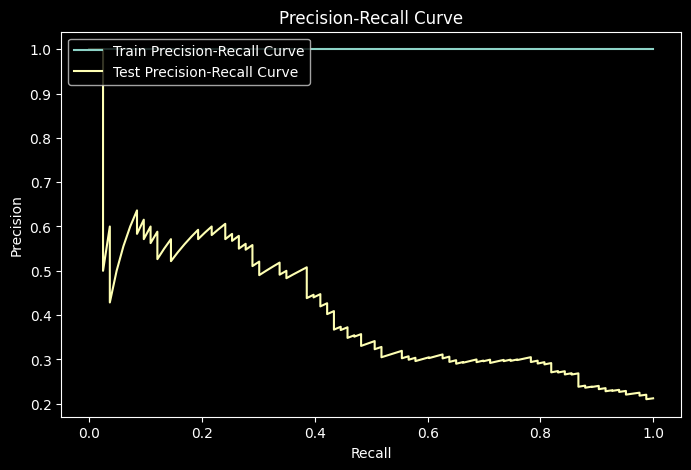

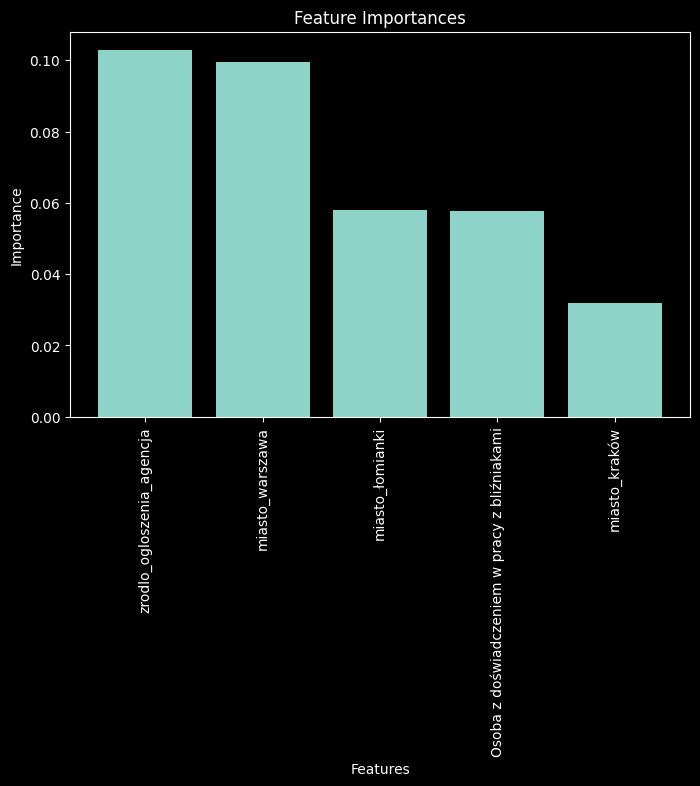

<Figure size 1000x800 with 0 Axes>

In [206]:
for element in range(len(algo_drzewa)):
    print(nazwy[element])
    all_tree(algo_drzewa[element], param_drzewa[element], nazwy[element])


Checking the results:

In [207]:
res = pd.DataFrame(results)
res.sort_values('f1_test', ascending = False)

,model,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test,auc_train,auc_test
2,xgb_tree,0.996,0.686,0.985,0.631,0.985,0.409,1.000,0.720
0,dec_tree,0.726,0.619,0.627,0.582,0.404,0.311,0.819,0.622
1,random_f,0.901,0.847,0.588,0.541,0.299,0.154,0.956,0.720


Now I'm creating neural network model

First I'm scaling the data:

In [208]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [209]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = random_state)
print(len(X), len(X_train), len(X_test), len(y_train), len(y_test))

1424 996 428 996 428


In [210]:
import tensorflow as tf
from tensorflow.keras import regularizers
model = Sequential()
model.add(tf.keras.layers.Dense(256, input_shape = (52,),activity_regularizer=regularizers.l1(10e-5)))
model.add(tf.keras.layers.PReLU(input_shape=(24,))) # z tego co kojarzę akurat funkcja aktywacji PReLU musi być osobno, normalnie możesz wrzucać funkcję aktywacji do linijki wyżej
model.add(tf.keras.layers.Dropout(rate=0.7))
model.add(tf.keras.layers.Dense(16, activity_regularizer=regularizers.l1(10e-5)))
model.add(tf.keras.layers.PReLU(input_shape=(28,)))
model.add(tf.keras.layers.Dense(1, activation="sigmoid", activity_regularizer=regularizers.l1(10e-5)))
model.summary()

model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy())
model.fit(X_train, y_train, batch_size=128, epochs=20)
model.fit(X_train, y_train, batch_size=32, epochs=80)

y_pred = model.predict(X_test)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 256)               13568     
                                                                 
 p_re_lu_14 (PReLU)          (None, 256)               256       
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_25 (Dense)            (None, 16)                4112      
                                                                 
 p_re_lu_15 (PReLU)          (None, 16)                16        
                                                                 
 dense_26 (Dense)            (None, 1)                 17        
                                                                 
Total params: 17,969
Trainable params: 17,969
Non-trai

Epoch 69/80
32/32 [==============================] - 0s 3ms/step - loss: 0.2428
Epoch 70/80
32/32 [==============================] - 0s 3ms/step - loss: 0.2435
Epoch 71/80
32/32 [==============================] - 0s 2ms/step - loss: 0.2506
Epoch 72/80
32/32 [==============================] - 0s 2ms/step - loss: 0.2204
Epoch 73/80
32/32 [==============================] - 0s 2ms/step - loss: 0.2302
Epoch 74/80
32/32 [==============================] - 0s 2ms/step - loss: 0.2098
Epoch 75/80
32/32 [==============================] - 0s 3ms/step - loss: 0.2225
Epoch 76/80
32/32 [==============================] - 0s 3ms/step - loss: 0.2266
Epoch 77/80
32/32 [==============================] - 0s 2ms/step - loss: 0.2133
Epoch 78/80
32/32 [==============================] - 0s 2ms/step - loss: 0.2298
Epoch 79/80
32/32 [==============================] - 0s 2ms/step - loss: 0.2326
Epoch 80/80
14/14 [==============================] - 0s 1ms/step


In [211]:
y_pred_train = model.predict(X_train)
y_pred_labels_train = (y_pred_train > 0.5).astype(int)

accuracy_t = accuracy_score(y_train, y_pred_labels_train)
precision_t = precision_score(y_train, y_pred_labels_train)
recall_t = recall_score(y_train, y_pred_labels_train)
f1_t = f1_score(y_train, y_pred_labels_train)
auc_t = roc_auc_score(y_train, y_pred_labels_train)

y_pred_test = model.predict(X_test)
y_pred_labels_test = (y_pred_test > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred_labels_test)
precision = precision_score(y_test, y_pred_labels_test)
recall = recall_score(y_test, y_pred_labels_test)
f1 = f1_score(y_test, y_pred_labels_test)
auc = roc_auc_score(y_test, y_pred_labels_test)

results['model'].append('neural network')
results['precision_train'].append(precision_t.round(3))
results['precision_test'].append(precision.round(3))
results['recall_train'].append(recall_t.round(3))
results['recall_test'].append(recall.round(3))
results['f1_train'].append(f1_t.round(3))
results['f1_test'].append(f1.round(3))
results['auc_train'].append(auc_t.round(3))
results['auc_test'].append(auc.round(3))

14/14 [==============================] - 0s 1ms/step


Checking results with neural network algorithm:

In [213]:
res = pd.DataFrame(results)
res.sort_values('f1_test', ascending = False)

,model,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test,auc_train,auc_test
2,xgb_tree,0.996,0.686,0.985,0.631,0.985,0.409,1.000,0.720
0,dec_tree,0.726,0.619,0.627,0.582,0.404,0.311,0.819,0.622
3,neural network,0.950,0.432,0.773,0.229,0.852,0.299,0.881,0.578
1,random_f,0.901,0.847,0.588,0.541,0.299,0.154,0.956,0.720
